## Welcome to Video2Music!

This notebook is designed to be run on Colab and on CPU, to avoid any issues. The whole demo is based on the code by [Kang et al. (2024)](https://github.com/AMAAI-Lab/Video2Music/tree/main).

In the first part of this notebook, you can upload a video for which you would like to generate matching music. As the encoding of the video is very resource-intense, in the second part you can play around with the audio generation part, trying to modify the output by setting the emotion and semantic setting by yourself.

Unfortunately, the model requires you to download some stuff manually, but bear with me through the process, it is not as bad as you might think now.

To get the Video2Music model running, we need a specific python version, for that we have to do some workarounds in colab, this is what the following cells are about.

**After executing the following cell, the session will crash**, but don't be scared! That is deliberate and needed so that condacolab works correctly.

You do not have to do anything, just continue with the next cells.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()


⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:11
🔁 Restarting kernel...


Now we install all the different packages and stuff we need.

In [ ]:
import condacolab
condacolab.check()
!conda create -n py38 python=3.8 -y
!source /usr/local/etc/profile.d/conda.sh && conda activate py38 && python --version

# install ffmeg and fluidsynth
!apt-get update
!apt-get install -y ffmpeg fluidsynth

# clone git repo for Video2Music
!git clone https://github.com/Ally511/Video2Music.git
%cd Video2Music

# install dependencies
!source /usr/local/etc/profile.d/conda.sh && conda activate py38 && conda install pip && pip install -r requirements.txt

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 25.5.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local/envs/py38

  added / updated specs:
    - python=3.8


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.6.15  |       hbd8a1cb_0         148 KB  conda-forge
    ld_impl_linux-64-2.44      |       h1423503_0         660 KB  conda-forge
    libffi-3.4.6               |       h2dba641_1          56 KB  conda-forge
    libgcc-15.1.0              |       h767d61c_3         806 KB  conda-forge
    libgcc-ng-15.1.0           |       h69a702a_3          28 KB  conda-forge
    libgomp-15.1.0             |       h767d61c_3         437

We need to upload some files by hand that are too big to store them on a github repository. First, since the Video2Music model works with CLIP encoding, we need to load that too. Since installing it via cloning the git is somewhat unstable and often causes problems, we do it manually. Go to https://github.com/openai/CLIP, click on "Code" and "Local" and Download the zip, which you then upload here via the following cell to install clip.

In [ ]:
from google.colab import files
# upload the CLIP-main.zip
uploaded = files.upload()
!unzip CLIP-main.zip -d clip_src
%cd /content/Video2Music/clip_src/CLIP-main/
#install clip
!source /usr/local/etc/profile.d/conda.sh && conda activate py38 && pip install .

Saving CLIP-main.zip to CLIP-main.zip
Archive:  CLIP-main.zip
dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
   creating: clip_src/CLIP-main/
   creating: clip_src/CLIP-main/.github/
   creating: clip_src/CLIP-main/.github/workflows/
  inflating: clip_src/CLIP-main/.github/workflows/test.yml  
  inflating: clip_src/CLIP-main/.gitignore  
  inflating: clip_src/CLIP-main/CLIP.png  
  inflating: clip_src/CLIP-main/LICENSE  
 extracting: clip_src/CLIP-main/MANIFEST.in  
  inflating: clip_src/CLIP-main/README.md  
   creating: clip_src/CLIP-main/clip/
 extracting: clip_src/CLIP-main/clip/__init__.py  
 extracting: clip_src/CLIP-main/clip/bpe_simple_vocab_16e6.txt.gz  
  inflating: clip_src/CLIP-main/clip/clip.py  
  inflating: clip_src/CLIP-main/clip/model.py  
  inflating: clip_src/CLIP-main/clip/simple_tokenizer.py  
   creating: clip_src/CLIP-main/data/
  inflating: clip_src/CLIP-main/data/country211.md  
  inflating: clip_src/CLIP-main/data/prompts.md  
  inflating: clip_src/CLIP-main/data/re

We now need to upload the model's weights that you get from [HERE](https://drive.google.com/file/d/1qpcBXF04pgdy9hqRexr0mTx7L9_CAFpt/view?usp=drive_link) and the soundfonts you can download from [HERE](https://drive.google.com/file/d/1B9qjgimW9h6Gg5k8PZNt_ArWwSMJ4WuJ/view?usp=drive_link).
This will take a while (5-10 minutes per file), since both files are quite large.
Use the following cells to first load the AMT weights and then the soundfonts.

In [ ]:
# upload the weights (the AMT.zip)
uploaded = files.upload()
!unzip AMT.zip -d /content/Video2Music/saved_models/

Saving AMT.zip to AMT.zip
Archive:  AMT.zip
  inflating: /content/Video2Music/saved_models/AMT/best_rmse_weights.pickle  
  inflating: /content/Video2Music/saved_models/AMT/best_loss_weights.pickle  


In [ ]:
#upload the soundfonts
uploaded = files.upload()
!mv default_sound_font.sf2 /content/Video2Music/soundfonts/

Saving default_sound_font.sf2 to default_sound_font.sf2


## Getting started with Video-audio generation
If you want to use your own video file, you can upload it here. Otherwise, you can just use the path that is already defined in the script below.



---


###Video2Music model
Quick reminder here, how the inference works:


*  **Feature Extraction:** the chord primer sequence is encoded as well as the different video features, namely
    * semantic and emotion via CLIP
    * scene offset via PySceneDetect
    * motion via RGB difference

*   **ATM encoder**: the video features are passed through the Affective Multimodal Transformer encoder using Multihead Attention
* **ATM decoder**: combines music and ATM encoded Video features, using Cross-Attention; each new chord is conditioned on the previously generated chord
* **Post-Processing**: a Bi-GRU gets the video features as input and determines from it the density and loudness of the chord sequence






In [ ]:
#upload your desired mp4 video file
uploaded = files.upload()

input_video = next(iter(uploaded))
print("Using uploaded file:", input_video)

!mv {input_video} /content/Video2Music/

Saving bird.mp4 to bird.mp4
Using uploaded file: bird.mp4


Now, we define the shell script to run inference. Depending on the length of your video, this may take a while, up to 1 hour, so use the time to make a cup of coffee which you can enjoy when listening to the wonderful music you get out of it! You can also try it with different chord sequences as primers. For that purpose, you have the chord-emotion table here again as a reference, also to know what different chords are possible.

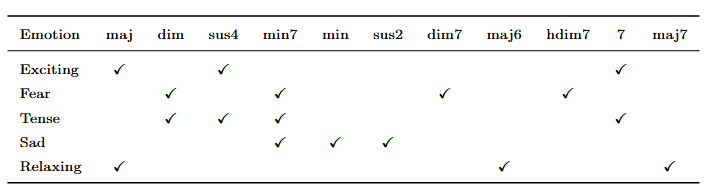

In [ ]:
%%writefile inference_script.py
import os
import sys

sys.path.append('/content/Video2Music')
os.chdir("/content/Video2Music")

from video2music import Video2music


input_video = "/content/Video2Music/bird.mp4" #adjust this path according to the name of your mp4

# modify that to your liking, check the table for different options
# but be aware - a major chord is NOT C maj, but just C; a minor chord is defined as Cm
# the rest you can just use as indicated in the table:)
input_primer = "C Am Gsus2 Gm"

# C major or A minor
input_key = "C major"

video2music = Video2music()

#generate the music video
output_filename = video2music.generate(input_video, input_primer, input_key)

Overwriting inference_script.py


This cell executes the script!

In [ ]:
# execute the script for inference
!source /usr/local/etc/profile.d/conda.sh && conda activate py38 && python inference_script.py


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
# Download the music video file
files.download("/content/Video2Music/output/output.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Audio Generation without Video Input

Since generating the music video can take a lot of time, I wrote a function to only generate the audio while being able to manipulate the emotion and semantics feature. So, you get the opportunity to choose by yourself which emotions you want to convey. You can play around with the different tensors ands see, what an imact it has on the generated audio.

This is the script for the audio generation, again, you can execute via the cell below.

In [ ]:
%%writefile audio_script.py
import os
import sys

sys.path.append('/content/Video2Music')
os.chdir("/content/Video2Music")

from video2music import Video2music
import torch

seed=42
torch.manual_seed(seed=seed)
# this is the semantic embedding vector, you can also try different versions by adjusting the Seed
semantic = torch.randn(300, 768)

# 0: exciting, 1: fearful, 2: tense, 3: sad, 4: relaxing, 5: neutral
emotion_tensor = torch.zeros(300, 6)

# like this, the whole video would be very relaxing, for different emotions, change the index
emotion_tensor[:, 4] = 1.0  # should range between 0.0 and 1.0, defines the intensity of the emotion

# adjust this to you liking (again check the table above for the different options)
primer = "Cmaj7 Gm7 Amdim7 Fhdim7" # you might also try what happens if the emotion tensor defined above contradicts the emotions conveyed by the chords:)

# C major or A minor
key = "A minor"


video2music = Video2music()
# generate the audio
output_filename = video2music.audio_generate(emotion_tensor, semantic, primer, key)

Overwriting audio_script.py


In [ ]:
# execute the script for audio only inference
!source /usr/local/etc/profile.d/conda.sh && conda activate py38 && python audio_script.py


pchord is  C:maj7
pchord is  G:min7
pchord is  A:mdim7
Traceback (most recent call last):
  File "audio_script.py", line 30, in <module>
    output_filename = video2music.audio_generate(emotion_tensor, semantic, primer, key)
  File "/content/Video2Music/video2music.py", line 508, in audio_generate
    chordID = chordDic[pChord]
KeyError: 'A:mdim7'


In [ ]:
# download the audio file
files.download("/content/Video2Music/output/output.mp3")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>